In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import regionmask
import pandas as pd
import xesmf as xe


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Import our data

#### Import GC output

In [2]:
GC_new = xr.open_mfdataset('../../GCrundirs/benchmark_annual_EPA/geosfp_4x5_benchmark/OutputDir/GEOSChem.AerosolMass.2016*_0000z.nc4', combine = 'by_coords') #dataset with the kgC/m2/s and kgNO2/m2/s

GC_new.attrs['name'] = 'EPA2016'


In [35]:
GC_new = xr.open_mfdataset('../../GCrundirs/benchmark_annual_EPA/geosfp_4x5_benchmark/OutputDir/GEOSChem.LevelEdgeDiags.2016*_0000z.nc4', combine = 'by_coords') #dataset with the kgC/m2/s and kgNO2/m2/s


## Plot the NOx for each GC run

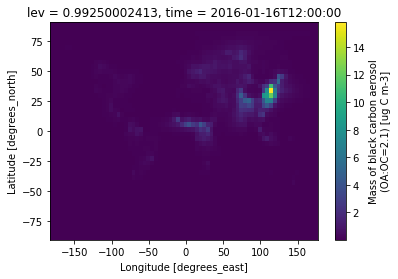

In [3]:
GC_new['AerMassBC'].isel(lev = 0, time = 0).plot()

## Mask our datasets to just the contiguous US

In [4]:
ds_out = xr.Dataset({'lat': (['lat'], GC_new['lat']),
                     'lon': (['lon'], GC_new['lon']),
                    }
                   )

Reuse existing file: bilinear_181x360_46x72.nc
using dimensions ('lat', 'lon') from data variable MASK as the horizontal dimensions for this dataset.


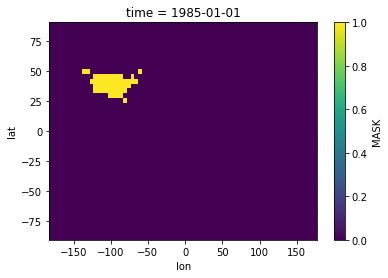

In [5]:
mask = xr.open_dataset('../../masks/USA_mask.geos.1x1.nc')

#### create regridder (reusing weights) to regrid our mask to 4x5 resolution ####
regridder = xe.Regridder(mask, ds_out, 'bilinear', reuse_weights = True)
regridder  # print basic regridder information.

#### regrid ####
regrid_mask = regridder(mask)
regrid_mask = regrid_mask.squeeze()

### plot our mask ####
regrid_mask['MASK'].plot()

In [6]:
GC_US_new = GC_new.where(regrid_mask['MASK'] ==1)


In [11]:
# Extract the grid box surface area values f(in units of m^2) 
# from the xarray Dataset object into a numpy array.
# This is done by using with the .values tag.
area = GC_US_new['AREA'].values 

# Print the shape of the area array
print( "Original shape of AREA: {}".format( area.shape ) )

# Reshape area from (46,72) to (1,46,72) to be consistent with the 
# emissions data variables in the file.  If the array shapes are the same,
# we can multiply each emissions data array directly by the area array.
area = area[ np.newaxis, :, : ]

# Print the new of the area array
print( "New shape of AREA: {}".format( area.shape ) )

sec_in_month = 31.0 * 86400.0 

Original shape of AREA: (12, 46, 72)
New shape of AREA: (1, 12, 46, 72)


In [32]:
GC_US_new['AREA']

<xarray.DataArray 'AREA' (time: 12, lat: 46, lon: 72)>
dask.array<where, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72)>
Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes:
    long_name:  Surface area
    units:      m2

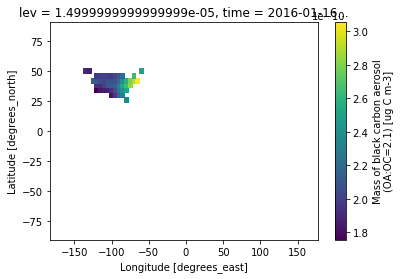

In [31]:
GC_US_new['AerMassBC'].isel(lev = -1, time = 0).plot()

In [22]:
(GC_US_new['AerMassBC']* GC_US_new['AREA']*GC_US_new['lev']).sum(dim = ['lev', 'time', 'lat', 'lon'], skipna = True).values*1E-18 

0.00011475426208075931

#### NO2 concentrations in our HEMCO diagnostics output

In [21]:
m2_s = HEMCO_US_ds['AREA'] * 60 * 60 * 24 * 31
no_no2 = 30/46
NOx_avgrate_orig = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig').sum(dim = 'lev') +
                HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig').sum(dim = 'lev') #+
                ).mean().values.item()

NOx_avgrate_new = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new').sum(dim = 'lev') +
                HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new') +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new').sum(dim = 'lev') #+
               ).mean().values.item()

print(NOx_avgrate_new, 'kg NOx/m2/s from new NEI')
print(NOx_avgrate_orig, 'kg NOx/m2/s from old NEI')

2.1374995523570917e-11 kg NOx/m2/s from new NEI
2.5476940002100434e-11 kg NOx/m2/s from old NEI


In [31]:

m2_s = HEMCO_US_ds['AREA'].sel(name = 'new') * 60 * 60 * 24 * 31
no2_no = 46.0055/30.01
n_no2 = 14.0067 / 46.0055 

#first mutliply by area and seconds/month, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig')*m2_s).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig')*m2_s).sum(dim = 'lev') * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new')*m2_s).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new')*m2_s) * no2_no * n_no2 +
                (HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new')*m2_s).sum(dim = 'lev') * n_no2
               ).sum().values.item() * 0.00110231


print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

269140.4017951061 short tons N from new NEI
320301.0639987929 short tons N from old NEI


In [29]:
(HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig')*m2_s).sum(dim = 'lev')

<xarray.DataArray (time: 1, lat: 46, lon: 72, name: 2)>
array([[[[0., 0.],
         ...,
         [0., 0.]],

        ...,

        [[0., 0.],
         ...,
         [0., 0.]]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * name     (name) object 'new' 'orig'

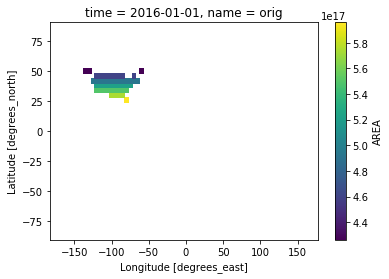

In [26]:
(HEMCO_US_ds['AREA'] * 60 * 60 * 24 * 31).sel(name = 'orig').plot()

In [18]:
no2_no * n_no2

0.4667344218593802

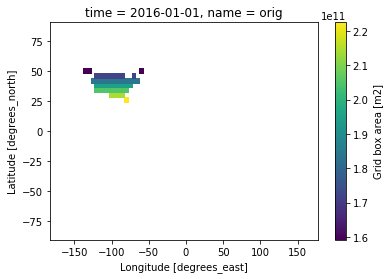

In [17]:
HEMCO_US_ds['AREA'].sel(name = 'orig').plot()

In [30]:
m2_s_in_6hours =HEMCO_new_US['AREA'].isel(time = 0)* 60 * 60 * 6
m2_s_in_month = HEMCO_orig_US['AREA'] * 60 * 60 * 24 * 31
no2_no = 46.0055/30.01
n_no2 = 14.0067 / 46.0055 

#first mutliply by area and seconds/6 hours, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_orig_US['EmisNO_Anthro']*m2_s_in_month).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_orig_US['EmisNO_BioBurn']*m2_s_in_month) * no2_no * n_no2 +
                (HEMCO_orig_US['EmisNO2_Anthro']*m2_s_in_month).sum(dim = 'lev') * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_new_US['EmisNO_Anthro']*m2_s_in_6hours).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_new_US['EmisNO_BioBurn']*m2_s_in_6hours) * no2_no * n_no2 +
                (HEMCO_new_US['EmisNO2_Anthro']*m2_s_in_6hours).sum(dim = 'lev') * n_no2
               ).sum().values.item() * 0.00110231


print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

261884.08233649557 short tons N from new NEI
320301.0639987929 short tons N from old NEI


### Import reference data

In [195]:
monthlycounty = pd.read_excel('2011ek_county_monthly_report.xlsx', sheet_name = 'data')

In [196]:
monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv'])

sector
nonpt              100011.717201
nonroad             80702.298394
np_oilgas           55805.711117
onroad             380361.625219
onroad_catx_adj     62300.771291
pt_oilgas           43292.677495
ptegu              206625.771302
ptnonipm           102524.124688
rail                67213.131517
rwc                  7599.175075
Name: jan_value, dtype: float64

In [189]:
monthlycounty2016 = pd.read_csv('2016fh_county_monthly_report_22jan2020_v0.csv', comment='#')

In [190]:
np.unique(monthlycounty2016['census_tract_cd'])

array(['afdust_adj', 'ag', 'airports', 'beis', 'cmv_c1c2_12', 'cmv_c3_12',
       'nonpt', 'nonroad', 'np_oilgas', 'onroad', 'onroad_ca_adj',
       'pt_oilgas', 'ptagfire', 'ptegu', 'ptfire', 'ptnonipm', 'rail',
       'rwc'], dtype=object)

In [191]:
month_abbrev = ['jan','feb','mar','apr','may','jun','jul','aug','sep','nov','dec']
month_value = [f'{month}_value' for month in month_abbrev]
month_value.append('ann_value')

In [197]:
NOx_ref2011 =  monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [193]:
NOx_ref = monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'census_tract_cd').sum()['jan_value'].drop(
    ['beis','ptfire','ptagfire', 'cmv_c1c2_12','cmv_c3_12']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [203]:
NOx_conc_new

261884.08233649557

In [201]:
print(NOx_ref, 'short tons N (no fire, beis, cmv)') 

786548.2492405875 short tons N (no fire, beis, cmv)


In [202]:
print('new NEI to reference', NOx_conc_new/NOx_ref)

new NEI to reference 0.33295361421164527
